# Simulating the unit circle

Consider the following scenario. Let $X$ be a dataset with two columns denoted by $X_r$ and $X_a$ respectively, each containing $n \in [50, 100]$ values. The values of $X_a$ are drawn from the interval $[-2\pi, 2\pi]$ while those in $X_r$ may take values from $[0, 2]$.

Our aim is to find a dataset $X$ that maximises the following function:
$$
f(X) = \frac{\text{Var}\left(X_{a}\right)}{\max_{x \in X_r} \left|x - 1\right|}
$$

That is, a dataset which maximises the variance of one column and minimises the maximal distance from one of the other.

Such a dataset would describe the polar coordinates of some set of points along the unit circle where the points in $X_r$ corresponds to the radii and those in $X_a$ correspond to the angle from the origin in radians.

## Formulation

For the sake of ease, we will assume that each column of $X$ can be uniformly distributed between the prescribed bounds.

Then, to formulate this scenario in `edo`, we will have to create some copies of the `Uniform` class.

In [1]:
import edo
import numpy as np
import pandas as pd
from edo.distributions import Uniform

In [2]:
class RadiusUniform(Uniform):

    name = "RadiusUniform"
    param_limits = {"bounds": [0, 2]}


class AngleUniform(Uniform):

    name = "AngleUniform"
    param_limits = {"bounds": [-2 * np.pi, 2 * np.pi]}

To keep track of which column is which when calculating the fitness of an individual, we will use a function to extract that information from the metadata.

In [3]:
def split_individual(individual):
    """ Separate the columns of an individual's dataframe. """

    df, metadata = individual
    names = [m.name for m in metadata]
    radii = df[names.index("RadiusUniform")]
    angles = df[names.index("AngleUniform")]

    return radii, angles


def fitness(individual):
    """ Determine the similarity of the dataset to the unit circle. """

    radii, angles = split_individual(individual)
    return angles.var() / (radii - 1).abs().max()

Given that this is a somewhat more complicated task than the previous tutorial, we will employ the following measures:

- A smaller proportion of the best individuals in a population will be used to create parents
- The algorithm will be run using several seeds to explore more of the search space and to have a higher degree of confidence in the output of ``edo``

In [4]:
pop_histories, fit_histories = [], []
for seed in range(5):

    families = [edo.Family(RadiusUniform), edo.Family(AngleUniform)]

    opt = edo.DataOptimiser(
        fitness,
        size=100,
        row_limits=[50, 100],
        col_limits=[(1, 1), (1, 1)],
        families=families,
        max_iter=30,
        best_prop=0.1,
        maximise=True,
    )

    pops, fits = opt.run(random_state=seed)

    fits["seed"] = seed
    pop_histories.append(pops)
    fit_histories.append(fits)

fit_history = pd.concat(fit_histories)

## Visualising the results

As before, we can plot the fitness progression across these runs using `matplotlib`.

In [5]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Fitness')

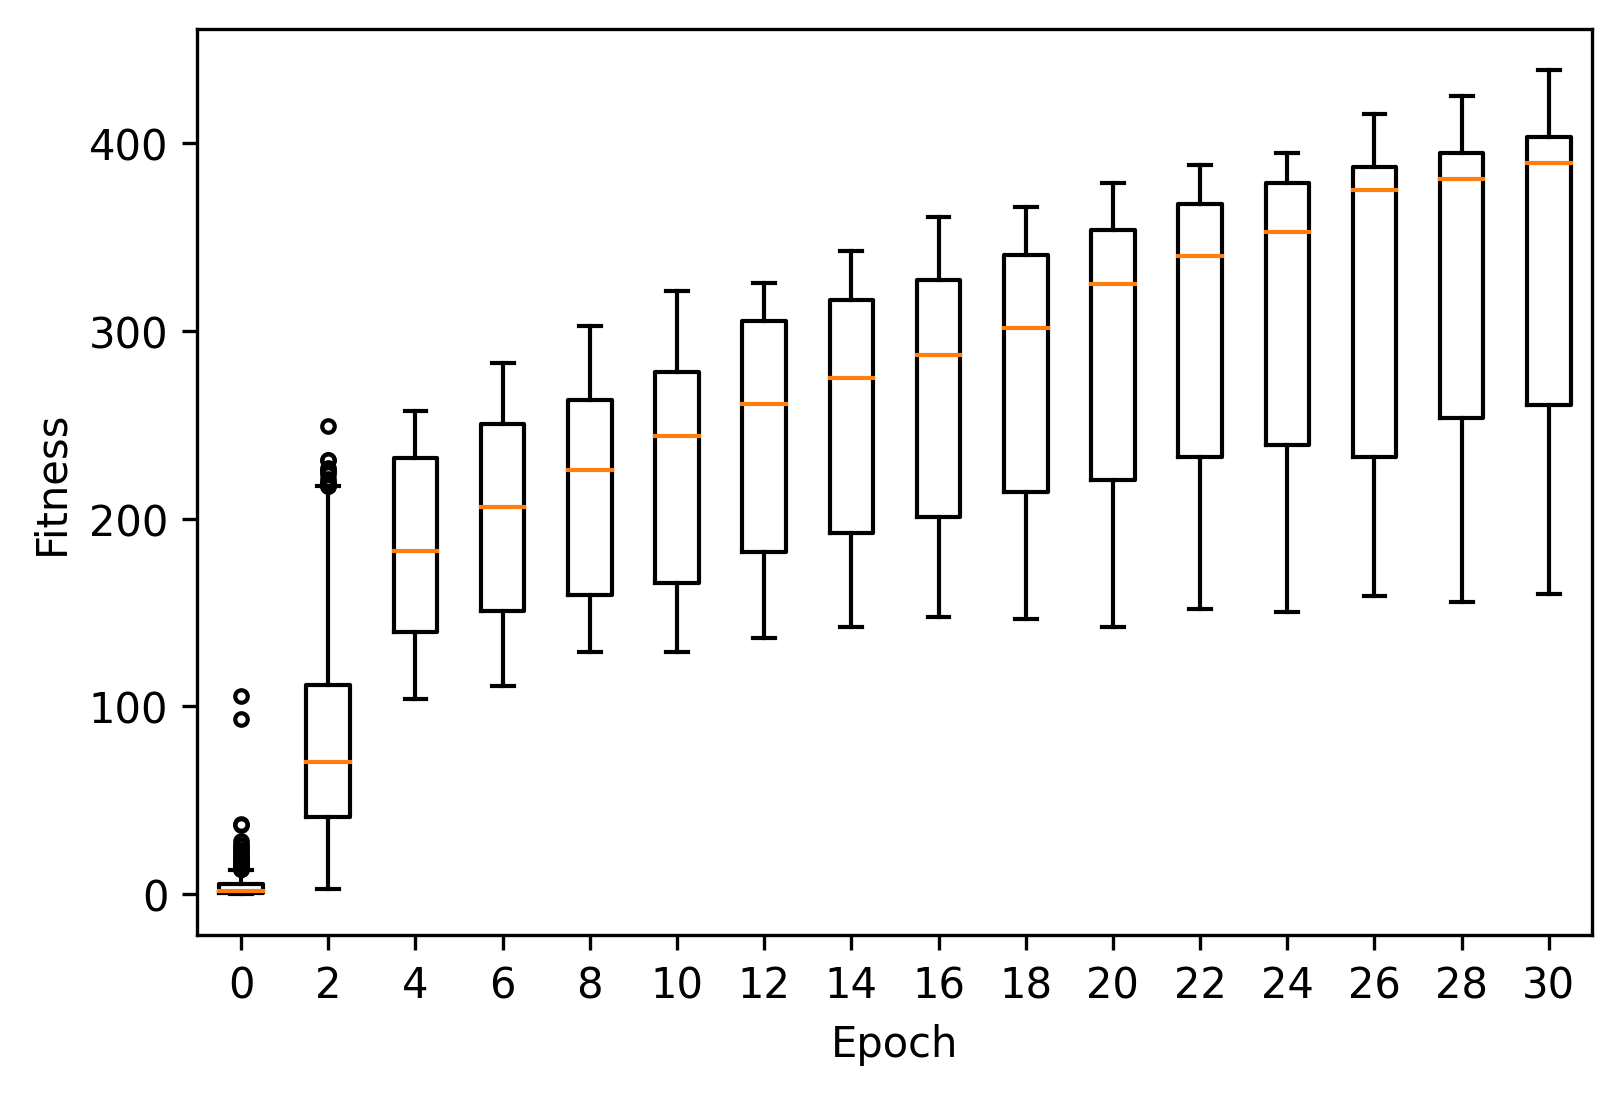

In [6]:
_, ax = plt.subplots(dpi=300)

epochs = range(0, 31, 2)
fit = fit_history[fit_history["generation"].isin(epochs)]

xticklabels = []
for pos, (gen, data) in enumerate(fit.groupby("generation")):
    ax.boxplot(data["fitness"], positions=[pos], widths=0.5, sym=".")
    xticklabels.append(gen)

ax.set_xticklabels(xticklabels)
ax.set_xlabel("Epoch")
ax.set_ylabel("Fitness")

We can also take a look at the best individual across all runs.

In [7]:
idx = fit_history["fitness"].idxmax()
seed, gen, ind = fit_history[["seed", "generation", "individual"]].iloc[idx]

best = pop_histories[seed][gen][ind]
seed, gen, ind, best

(0,
 30,
 49,
 Individual(dataframe=           0         1
 0   1.005690 -4.928099
 1   0.971288  1.524298
 2   1.000057 -5.924903
 3   0.941059  2.931472
 4   0.984278  3.252393
 ..       ...       ...
 89  0.989021  4.615850
 90  1.022580  3.276894
 91  0.992919  3.266881
 92  1.027503 -4.978339
 93  1.004182  4.431548
 
 [94 rows x 2 columns], metadata=[Uniform(bounds=[0.93, 1.05]), Uniform(bounds=[-6.0, 4.74])]))

[(-1.5, 1.5), (-1.5, 1.5), None]

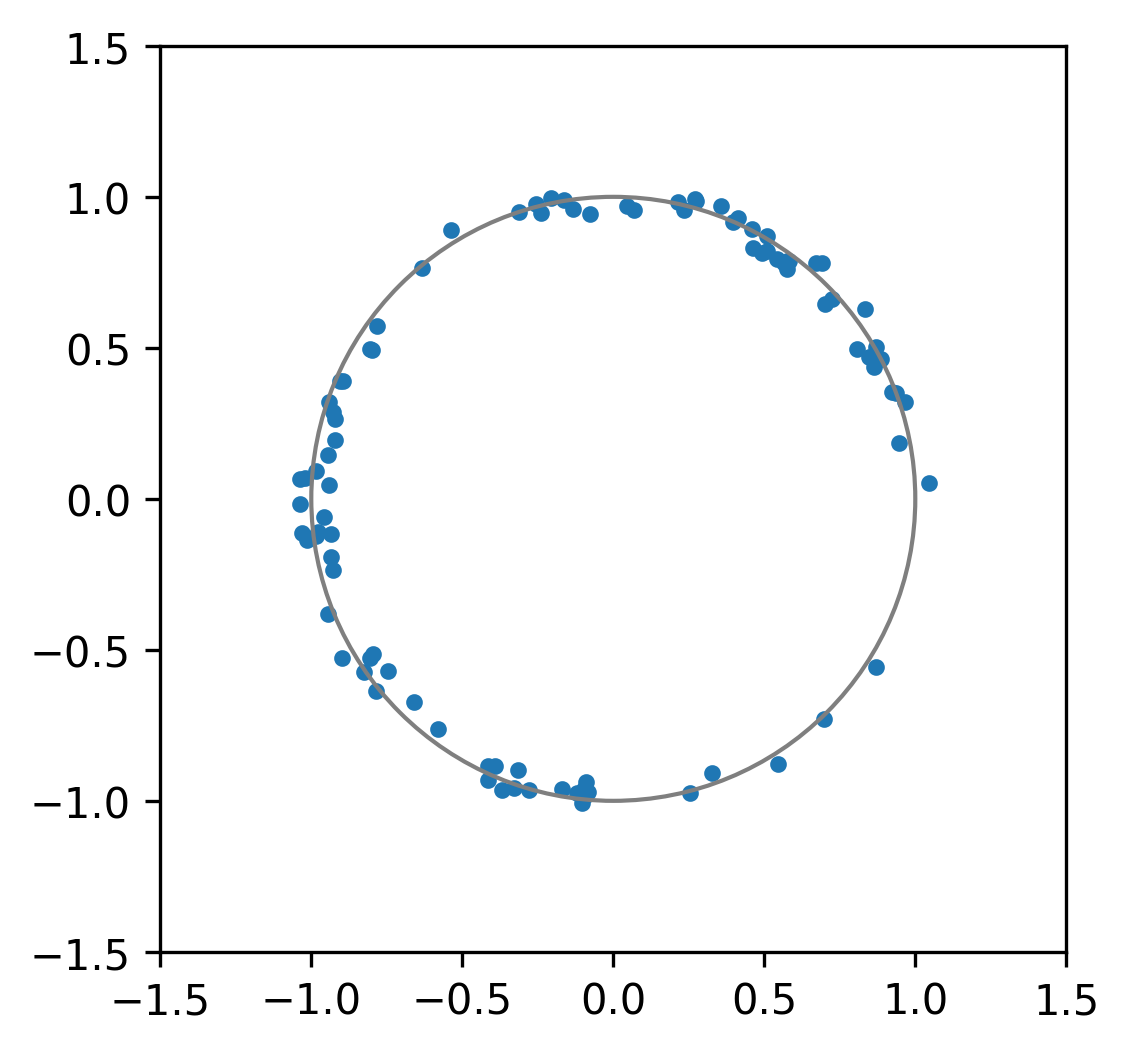

In [8]:
_, ax = plt.subplots(dpi=300)

circle = plt.Circle((0, 0), 1, fill=False, linestyle="-", color="tab:gray")
ax.add_artist(circle)

radii, angles = split_individual(best)
xs, ys = radii * np.cos(angles), radii * np.sin(angles)

scatter = ax.scatter(xs, ys, marker=".")

ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), aspect="equal")

That's a pretty good approximation to a circle. Nice.